In [0]:
!unzip images.zip

In [0]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class AStarNet(nn.Module):
  def __init__(self):
    super(AStarNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
    self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
    self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * 128, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256 + 4, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 8)

  def forward(self, x):
    config_states, maps = x
    maps = maps.unsqueeze(1).float().to("cuda")
    config_states = config_states.float().to("cuda")
    x = F.max_pool2d(F.relu(self.conv1(maps)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = F.max_pool2d(F.relu(self.conv4(x)), 2)
    x = F.max_pool2d(F.relu(self.conv5(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = torch.cat((x, config_states), axis=1)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [0]:
from dataloader import HolonomicDataset
from torch.utils.data import DataLoader
path = './'
dataset = HolonomicDataset('data.csv', path, grayscale=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [0]:
net = AStarNet().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
JHist = []

In [11]:
for j in range(100):
  for i, (input_data, labels) in enumerate(dataloader):

    y_label = labels.to("cuda")
    y_label = y_label - 1
    optimizer.zero_grad()
    y_pred = net(input_data)
    loss = criterion(y_pred, y_label)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    JHist.append(epoch_loss)
    
    print(i + j * 83, epoch_loss)

Streaming output truncated to the last 5000 lines.
2765 0.24603796005249023
2766 0.3088962435722351
2767 0.21553142368793488
2768 0.35714611411094666
2769 0.2863542139530182
2770 0.28634944558143616
2771 0.30288684368133545
2772 0.2535873353481293
2773 0.3037639260292053
2774 0.28815770149230957
2775 0.3184621334075928
2776 0.3313899040222168
2777 0.34219998121261597
2778 0.30730879306793213
2779 0.32464325428009033
2780 0.3523937463760376
2781 0.3065027892589569
2782 0.30513691902160645
2783 0.28205373883247375
2784 0.38062989711761475
2785 0.29639115929603577
2786 0.26949262619018555
2787 0.3077075779438019
2788 0.33441904187202454
2789 0.2715004086494446
2790 0.3198779821395874
2791 0.3025878071784973
2792 0.2568492293357849
2793 0.39756864309310913
2794 0.3244551122188568
2795 0.3560173213481903
2796 0.3873443007469177
2797 0.3380756676197052
2798 0.32830551266670227
2799 0.351287841796875
2800 0.34506258368492126
2801 0.2864574193954468
2802 0.32421430945396423
2803 0.251392930746

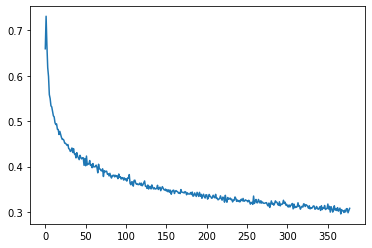

In [12]:
import matplotlib.pyplot as plt
JHist_avg = []
sum = 0
for index in range(30, len(JHist)):
  sum += JHist[index]
  if index % 99 == 0:
    JHist_avg.append(sum / 100)
    sum = 0

plt.plot(JHist_avg)

In [13]:
# check labels on all of training data
correct = 0
total = 0
for i, (input_data, labels) in enumerate(dataloader):
  test_input = input_data
  test_label = labels.to("cuda")

  y_pred = net(test_input)
  pred_actions = torch.argmax(y_pred, axis=1)
  
  total += pred_actions.shape[0]
  for j in range(pred_actions.shape[0]):
    if pred_actions[j] == test_label[j] - 1:
      correct += 1
print(correct / total)

0.8504623791509037


In [0]:
from google.colab import files
PATH = './AStarNet.pth'
torch.save(net.state_dict(), PATH)
files.download(PATH)